In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv("competition origin data/train.csv")
test_data = pd.read_csv("competition origin data/test.csv")

通过EDA我们已经看到了一些需要处理的问题，我们在特征工程中不仅要将EDA中发现的问题解决，还要处理更深入的特征问题

### 1.处理目标变量

先将ID列删除

In [3]:
train_ID = train_data['Id']
test_ID = test_data['Id']

train_data.drop(['Id'], axis=1, inplace=True)
test_data.drop(['Id'], axis=1, inplace=True)

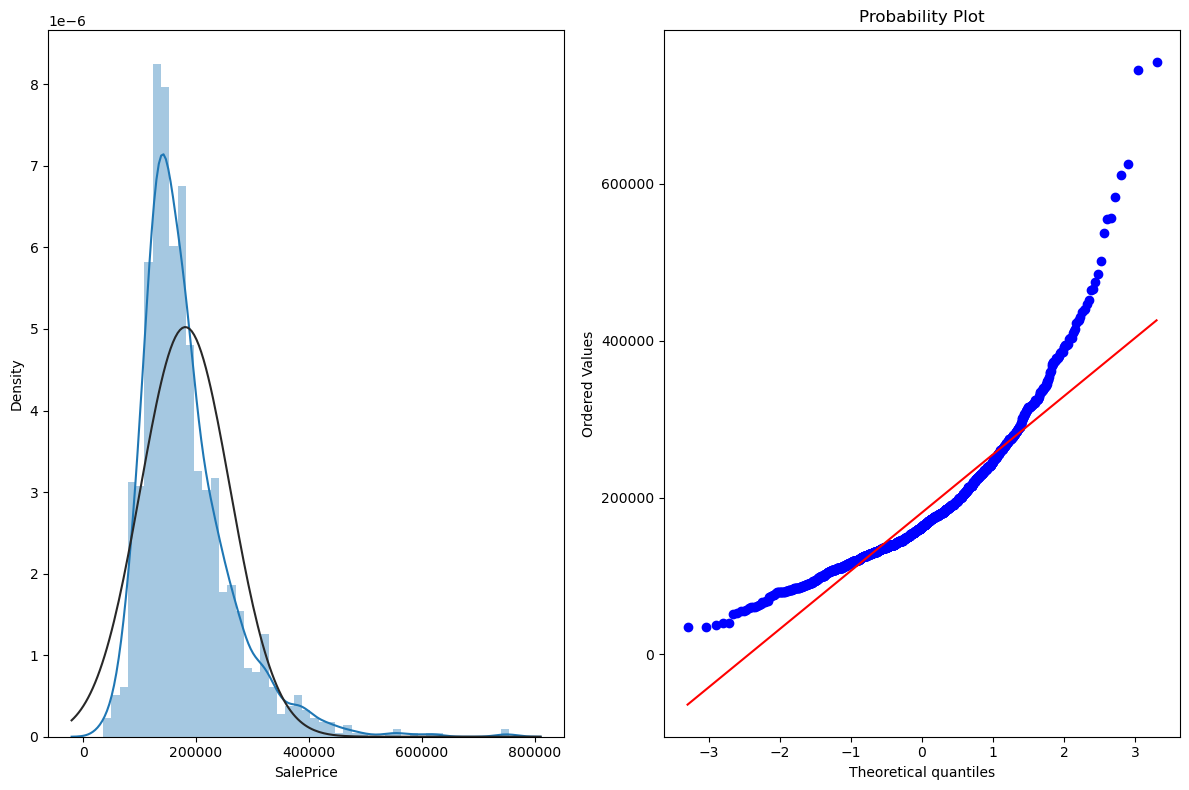

In [4]:
from scipy import stats

_, axes = plt.subplots(1, 2, figsize=(12, 8))

sns.distplot(train_data['SalePrice'], fit=stats.norm, ax=axes[0])
stats.probplot(train_data['SalePrice'], plot=axes[1])

plt.tight_layout()

plt.show()

在EDA中我们提到了目标变量呈现偏态分布且值域范围较大，可以用对数变换使其趋近于正态分布

**注意：我们对目标变量进行对数变换之后，一定要记得对预测结果进行逆变换**

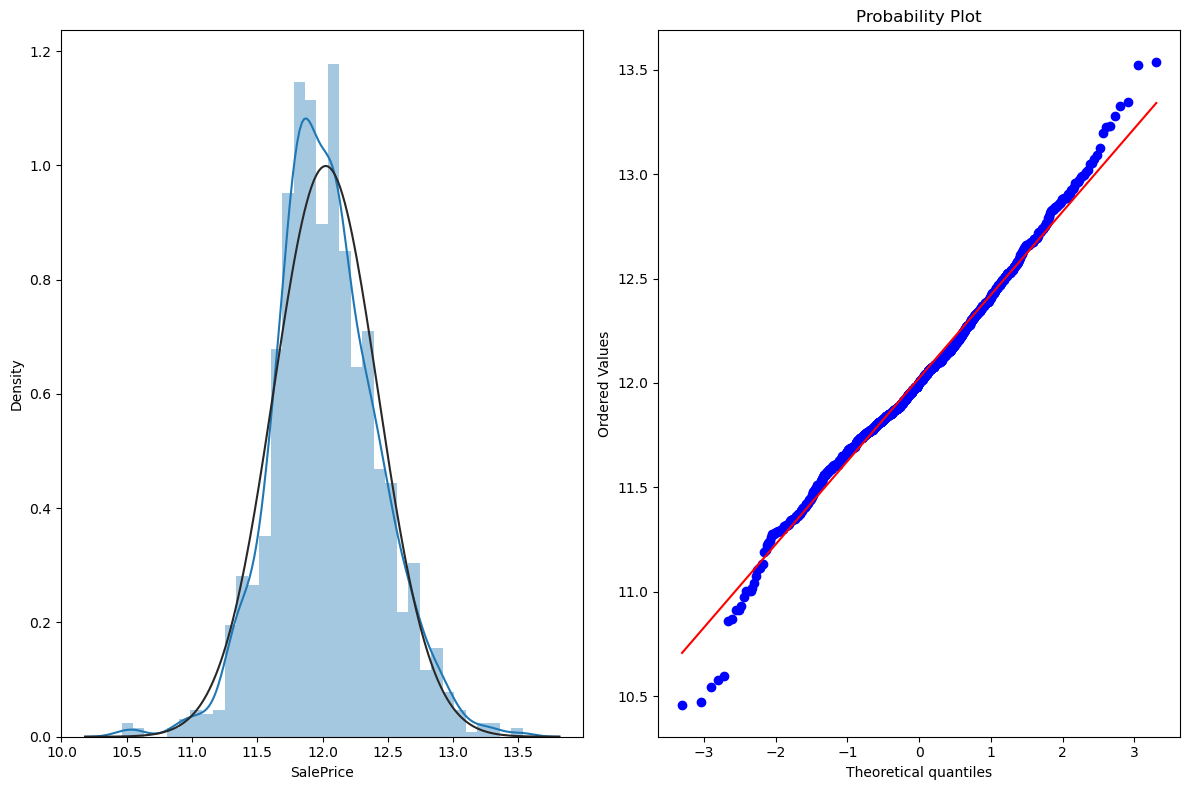

In [5]:
train_data['SalePrice'] = np.log1p(train_data['SalePrice']) #log1p=log(1+x) 防止某些变量为负数

_, axes = plt.subplots(1, 2, figsize=(12, 8))

sns.distplot(train_data['SalePrice'], fit=stats.norm, ax=axes[0])
stats.probplot(train_data['SalePrice'], plot=axes[1])

plt.tight_layout()

plt.show()

### 2.处理异常值

在EDA中我们提到了数据中有部分异常值，我们可以选择删除部分异常值点增加模型的鲁棒性，当然也可以选择不删除

在这里，我们选择了OverallQual和GrLivArea这两个与目标变量相关性最高的两个特征进行异常值处理

In [6]:
train_data.drop(train_data[(train_data['GrLivArea'] > 4500) & (train_data['SalePrice'] < 300000)].index, inplace=True)
train_data.drop(train_data[(train_data['OverallQual'] < 5) & (train_data['SalePrice'] > 200000)].index, inplace=True)
train_data.reset_index(drop=True, inplace=True)

保存删除异常值后的数据维度

In [7]:
train_label = train_data['SalePrice'].reset_index(drop=True)
train_features = train_data.drop(['SalePrice'], axis=1)

test_features = test_data

### 3.处理缺失值

很多选手把训练集和测试集合并在一起做缺失值处理，但我觉得，如果缺失值处理中涉及到了均值填充，中位数填充或众数填充等方法，则不应该把训练集和测试集合并，否则会造成数据泄露

如果缺失值不涉及计算可以直接填充，那么合并在一起处理是没有问题的

一般涉及到距离计算的模型对缺失值会比较敏感，例如KNN，支持向量机，线性模型

当然你也可以选择不做缺失值处理，使用对缺失值不敏感的树模型

定义查看缺失值比例函数

In [8]:
def missing_percentage(data, nums):
    null_data = data.isnull().sum().sort_values(ascending=False)
    percentage = data.isnull().sum()/data.isnull().count()
    missing_info = pd.concat([null_data, percentage.apply(lambda x: '{:.2%}'.format(x))], axis=1, keys=['total missing', 'missing percentage'])
    return missing_info.head(nums)

In [9]:
missing_percentage(train_features, 40)

,total missing,missing percentage
PoolQC,1452,99.59%
MiscFeature,1404,96.30%
Alley,1367,93.76%
Fence,1177,80.73%
FireplaceQu,690,47.33%
LotFrontage,259,17.76%
GarageType,81,5.56%
GarageYrBlt,81,5.56%
GarageQual,81,5.56%
GarageCond,81,5.56%


In [10]:
missing_percentage(test_features, 40)

,total missing,missing percentage
PoolQC,1456,99.79%
MiscFeature,1408,96.50%
Alley,1352,92.67%
Fence,1169,80.12%
FireplaceQu,730,50.03%
LotFrontage,227,15.56%
GarageYrBlt,78,5.35%
GarageFinish,78,5.35%
GarageQual,78,5.35%
GarageCond,78,5.35%


逐一对缺失值处理，先处理可以直接填充的特征

PoolQC, MiscFeature, Alley, Fence, FireplaceQu：这些特征里的空值代表样本房屋不包含泳池、篱笆等设施，因此用None来填充。

GarageType, GarageFinish, GarageQual, GarageCond 车库相关特征是类别型数据，用None来填充，缺失表示没有车库。

GarageYrBlt, GarageArea, GarageCars 车库相关特征是数值型数据，用0来填充，没有车库，这些数值型数据都是0。

BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2：地下室相关特征为类别型，用None来填充，缺失表示没有地下室。

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath：地下室相关特征为数值型，用0来填充，没有地下室，这些数值型数据都是0。

MasVnrArea, MasVnrType：缺失值值代表样本房屋不包含砖石贴面墙，因此分别用0和None来填充。

Functional：空值代表Typ（典型）。

In [11]:
def handle_missing_none_0(features):
    for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
        features[col] = features[col].fillna('None')
    
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
        
    for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
        features[col] = features[col].fillna(0)
        
    for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        features[col] = features[col].fillna('None')
    
    for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
        features[col] = features[col].fillna(0)
    
    features["MasVnrType"] = features["MasVnrType"].fillna("None")
    features["MasVnrArea"] = features["MasVnrArea"].fillna(0)
      
    features["Functional"] = features["Functional"].fillna("Typ")
    
    return features

train_features = handle_missing_none_0(train_features)
test_features = handle_missing_none_0(test_features)

还有剩下这些特征缺失值没有处理，这些特征涉及到计算，我们需要在训练集中获取相关的参数，将这些参数应用到测试集数据中

In [12]:
missing_percentage(train_features, 10)

,total missing,missing percentage
LotFrontage,259,17.76%
Electrical,1,0.07%
BedroomAbvGr,0,0.00%
GarageType,0,0.00%
FireplaceQu,0,0.00%
Fireplaces,0,0.00%
Functional,0,0.00%
TotRmsAbvGrd,0,0.00%
KitchenQual,0,0.00%
KitchenAbvGr,0,0.00%


In [13]:
missing_percentage(test_features, 10)

,total missing,missing percentage
LotFrontage,227,15.56%
MSZoning,4,0.27%
Utilities,2,0.14%
Exterior1st,1,0.07%
KitchenQual,1,0.07%
SaleType,1,0.07%
Exterior2nd,1,0.07%
GarageFinish,0,0.00%
GarageYrBlt,0,0.00%
GarageType,0,0.00%


LotFrontage：房屋与街道之间的直线距离（英尺），可以用同一个地区其他样本该项的中位数来补全。Neighborhood 是指房屋的地理位置。

MSZoning, Utilities, Electrical, KitchenQual, Exterior1st, Exterior2nd, SaleType：因为这些变量中仅有个别缺失值，可采用众数填充。

In [14]:
median_lotfrontage = train_features.groupby('Neighborhood')['LotFrontage'].median()

train_features['LotFrontage'] = train_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_features['LotFrontage'] = test_features.apply(lambda x: median_lotfrontage[x['Neighborhood']] 
                                                  if np.isnan(x['LotFrontage'])
                                                else  x['LotFrontage'], axis=1)

mode_values = {}
for col in ['MSZoning', 'Utilities', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    mode_value = train_features[col].mode()[0] 
    mode_values[col] = mode_value
    train_features[col] = train_features[col].fillna(mode_value)
for col in ['MSZoning', 'Utilities', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    test_features[col] = test_features[col].fillna(mode_values[col])

In [15]:
missing_percentage(train_features, 3)

,total missing,missing percentage
MSSubClass,0,0.00%
BedroomAbvGr,0,0.00%
GarageType,0,0.00%


In [16]:
missing_percentage(test_features, 3)

,total missing,missing percentage
MSSubClass,0,0.00%
BedroomAbvGr,0,0.00%
GarageType,0,0.00%


### 4.处理特征分布

目标变量呈现偏态分布，那么特征数据则也可能呈现偏态分布，我们同样可以对特征数据进行处理

1. 偏度是衡量随机变量概率分布的不对称性，是相对于平均值不对称程度的度量，通过对偏度系数的测量，我们能够判定数据分布的不对称程度以及方向。

   - 偏度大于 0 表示其数据分布形态与正太分布相比为正偏或右偏；有一条长尾巴在右边；
   - 反之左偏，即有一条长尾巴在左边
2. 峰度是研究数据分布陡峭或平滑的统计量，通过对峰度系数的测量，我们能够判定数据相对于正态分布而言是更陡峭/平缓。

   这个统计量需要与正态分布相比较，
   - 峰度为0表示该总体数据分布与正态分布的陡缓程度相同；
   - 峰度大于0表示该总体数据分布与正态分布相比较为陡峭，为尖顶峰；
   - 峰度小于0表示该总体数据分布与正态分布相比较为平坦，为平顶峰。
   峰度的绝对值数值越大表示其分布形态的陡缓程度与正态分布的差异程度越大。

通常我们只处理数值型特征的分布，所以要先将数值型特征和类别型特征分开

In [17]:
object_list = []

numerical_dtype = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerical_list = []


for col in train_features.columns:
    if train_features[col].dtype == 'object':
        object_list.append(col)
    elif train_features[col].dtype in numerical_dtype:
        numerical_list.append(col)
    else:
        print("opps")
        
print(object_list)
print("********")
print(numerical_list)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
********
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'

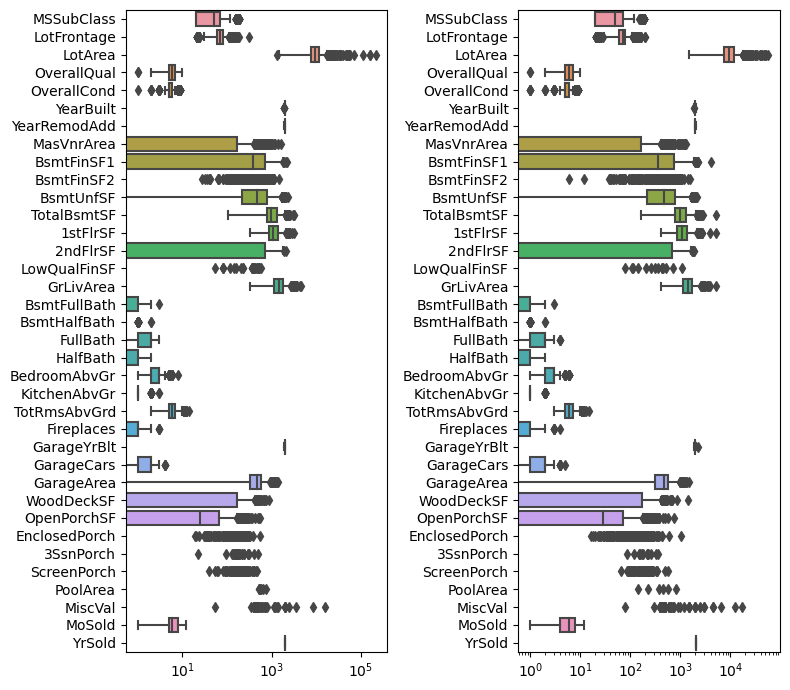

In [18]:
_, axes = plt.subplots(1, 2, figsize=(8, 7))

axes[0].set_xscale("log")
axes[0] = sns.boxplot(data=train_features[numerical_list], orient="h", ax=axes[0])

axes[1].set_xscale("log")
axes[1] = sns.boxplot(data=test_features[numerical_list], orient="h", ax=axes[1])

plt.tight_layout()
plt.show()

将偏度大于0.5的列为高偏特征，并将高偏特征排序并查看

In [19]:
skew_features_train = train_features[numerical_list].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skew_features_test = test_features[numerical_list].apply(lambda x: stats.skew(x)).sort_values(ascending=False)

high_skew_train = skew_features_train[skew_features_train > 0.5]
high_skew_test = skew_features_test[skew_features_test > 0.5]

skew_index_train = high_skew_train.index
skew_index_test = high_skew_test.index

print("There are {} numerical features with Skew > 0.5 in training set :".format(high_skew_train.shape[0]))
print("*****")
print("There are {} numerical features with Skew > 0.5 in testing set :".format(high_skew_test.shape[0]))

skew_features_train.head(10), skew_features_test.head(10)

There are 26 numerical features with Skew > 0.5 in training set :
*****
There are 25 numerical features with Skew > 0.5 in testing set :


(MiscVal          24.434913
 PoolArea         15.932532
 LotArea          12.560986
 3SsnPorch        10.286510
 LowQualFinSF      8.995688
 KitchenAbvGr      4.480268
 BsmtFinSF2        4.247550
 ScreenPorch       4.114690
 BsmtHalfBath      4.095895
 EnclosedPorch     3.083987
 dtype: float64,
 PoolArea         20.176117
 MiscVal          20.054543
 LowQualFinSF     16.150628
 3SsnPorch        12.511336
 EnclosedPorch     4.664371
 KitchenAbvGr      4.074860
 BsmtFinSF2        4.038796
 ScreenPorch       3.784349
 BsmtHalfBath      3.779085
 LotArea           3.112013
 dtype: float64)

将特征进行boxcox变换，同样我们要将训练集boxcox变换得到的参数记录下来并应用到测试集中，避免数据泄露

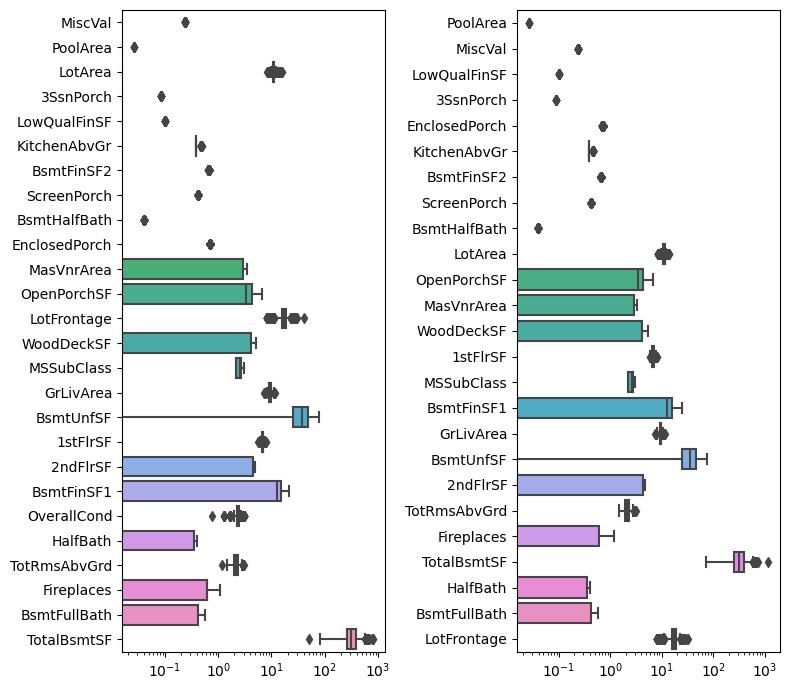

In [20]:
boxcox_params = {}

for i in skew_index_train:
    train_features[i], lambda_ = stats.boxcox(train_features[i]+1)
    boxcox_params[i] = lambda_
for i in skew_index_test:
    test_features[i] = stats.boxcox(test_features[i]+1, lmbda=boxcox_params[i])

_, axes = plt.subplots(1, 2, figsize=(8, 7))

axes[0].set_xscale("log")
axes[0] = sns.boxplot(data=train_features[skew_index_train], orient="h", ax=axes[0])

axes[1].set_xscale("log")
axes[1] = sns.boxplot(data=test_features[skew_index_test], orient="h", ax=axes[1])

plt.tight_layout()
plt.show()

### 5.特征扩充

特征扩充可以增加特征的数量和复杂度，增加模型对非线性特征的预测能力，从而提高模型的表达能力和预测精度

在特征扩充中，我们一般将训练集和测试集合并处理，因为要保证训练集和测试集维度一致

特征扩充不涉及样本之间的相互计算，只涉及到特征之间的计算，这并不会造成数据泄露

In [21]:
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 79)

定义了一些新特征，例如BsmtFinType1_Unf表示是否存在未完成的地下室，HasWoodDeck表示是否存在木制露台，HasOpenPorch表示是否存在开放式门廊等等，如果存在则为1， 否则为0

YearsSinceRemodel表示从翻新的年份到售出经过了多久，是通过将销售年份YrSold减去最近一次翻新的年份YearRemodAdd得到的。

Total_Home_Quality表示房屋总体质量，是将OverallQual和OverallCond两个特征相加得到的。

TotalSF表示房屋总面积，是将地下室面积TotalBsmtSF、一楼面积1stFlrSF和二楼面积2ndFlrSF三个特征相加得到的。

YrBltAndRemod表示房屋建造和最近一次翻新的年份之和，是将YearBuilt和YearRemodAdd两个特征相加得到的。

对一些二元特征进行处理，包括：PoolArea，2ndFlrSF，GarageArea，TotalBsmtSF 和 Fireplaces。这里将它们转换成布尔型的特征值，如果这些特征值大于 0，则将其设置为 1，否则设置为 0。

当然添加这些特征不是固定的，可以随心所欲添加很多特征进行特征扩充

In [22]:
def expand_features(features):
    features['BsmtFinType1_Unf'] = (features['BsmtFinType1'] == 'Unf') * 1
    features['HasWoodDeck'] = (features['WoodDeckSF'] == 0) * 1
    features['HasOpenPorch'] = (features['OpenPorchSF'] == 0) * 1
    features['HasEnclosedPorch'] = (features['EnclosedPorch'] == 0) * 1
    features['Has3SsnPorch'] = (features['3SsnPorch'] == 0) * 1
    features['HasScreenPorch'] = (features['ScreenPorch'] == 0) * 1
    
    features['YearsSinceRemodel'] = features['YrSold'].astype(int) - features['YearRemodAdd'].astype(int)
    features['Total_Home_Quality'] = features['OverallQual'] + features['OverallCond']
    features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
    features['YrBltAndRemod'] = features['YearBuilt'] + features['YearRemodAdd']
    
    features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])
    features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
    features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

    features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return features

all_features = expand_features(all_features)

In [23]:
object_list = []

numerical_dtype = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerical_list = []


for col in all_features.columns:
    if all_features[col].dtype == 'object':
        object_list.append(col)
    elif all_features[col].dtype in numerical_dtype:
        numerical_list.append(col)
    else:
        print("opps")
        
print(object_list)
print("********")
print(numerical_list)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
********
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'

### 6.特征选择

我们可以查看类别型变量中的unique值

In [24]:
for col in object_list:
    col_name = str(col)
    length = len(train_features[col_name].unique())
    train_features[col_name].value_counts(normalize = True)
    print("unique counts of {0}:{1}".format(col_name, length))
    print("********")

unique counts of MSZoning:5
********
unique counts of Street:2
********
unique counts of Alley:3
********
unique counts of LotShape:4
********
unique counts of LandContour:4
********
unique counts of Utilities:2
********
unique counts of LotConfig:5
********
unique counts of LandSlope:3
********
unique counts of Neighborhood:25
********
unique counts of Condition1:9
********
unique counts of Condition2:8
********
unique counts of BldgType:5
********
unique counts of HouseStyle:8
********
unique counts of RoofStyle:6
********
unique counts of RoofMatl:7
********
unique counts of Exterior1st:15
********
unique counts of Exterior2nd:16
********
unique counts of MasVnrType:4
********
unique counts of ExterQual:4
********
unique counts of ExterCond:5
********
unique counts of Foundation:6
********
unique counts of BsmtQual:5
********
unique counts of BsmtCond:5
********
unique counts of BsmtExposure:5
********
unique counts of BsmtFinType1:7
********
unique counts of BsmtFinType2:7
********

In [25]:
for col in object_list:
    col_name = str(col)
    length = len(test_features[col_name].unique())
    test_features[col_name].value_counts(normalize = True)
    print("unique counts of {0}:{1}".format(col_name, length))
    print("********")

unique counts of MSZoning:5
********
unique counts of Street:2
********
unique counts of Alley:3
********
unique counts of LotShape:4
********
unique counts of LandContour:4
********
unique counts of Utilities:1
********
unique counts of LotConfig:5
********
unique counts of LandSlope:3
********
unique counts of Neighborhood:25
********
unique counts of Condition1:9
********
unique counts of Condition2:5
********
unique counts of BldgType:5
********
unique counts of HouseStyle:7
********
unique counts of RoofStyle:6
********
unique counts of RoofMatl:4
********
unique counts of Exterior1st:13
********
unique counts of Exterior2nd:15
********
unique counts of MasVnrType:4
********
unique counts of ExterQual:4
********
unique counts of ExterCond:5
********
unique counts of Foundation:6
********
unique counts of BsmtQual:5
********
unique counts of BsmtCond:5
********
unique counts of BsmtExposure:5
********
unique counts of BsmtFinType1:7
********
unique counts of BsmtFinType2:7
********

我们可以发现Utilities特征在训练集中的Unique值为2，在测试集中的Unique值为1，说明这个特征对预测模型没有影响，可以直接删除

PoolQC特征在训练集中的Unique值为4，在测试集中的Unique值为3，但是从之前的统计可以知道其99%以上都是缺失值，也可以直接删除

In [26]:
all_features = all_features.drop(['Utilities', 'PoolQC'], axis=1)

### 7.特征转换和特征编码

有些特征虽然是数值型，但是这些数值型特征表示了某种程度，比如Total_Home_Quality, MSSubClass, OverallQual, OverallCond，它们数值从低到高表示了质量的好坏程度，这些数值型特征其实是类别型特征，要进行类别转换

In [27]:
cols = ['Total_Home_Quality', 'MSSubClass', 'OverallQual', 'OverallCond']

def numerical_to_object(features):
    for col in cols:
        features[col] = features[col].apply(str)
    return features

all_features = numerical_to_object(all_features)

机器学习模型无法识别类别型特征，所以要进行特征编码，将类别型特征转换为数值型特征才能够输入模型

对于隐含了顺序/等级意义的类别型特征要用LabelEncoder编码，对于Unique值较高的也要考虑采用LabelEncoder或其它编码

其它特征可以考虑使用one-hot编码

In [28]:
from sklearn.preprocessing import LabelEncoder

cols = ['Total_Home_Quality', 'MSSubClass', 'OverallQual', 'OverallCond', 'ExterQual', 
        'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
        'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']

for col in cols:
    labelencoder = LabelEncoder() 
    labelencoder.fit(list(all_features[col].values))
    all_features[col] = labelencoder.transform(list(all_features[col].values)) 
    
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features = all_features.loc[:,~all_features.columns.duplicated()]
print(all_features.shape)

(2917, 251)


### 8.特征提取（特征降维）

由于我们通过特征扩充增添了很多特征，而这些新增特征和原始特征是高度相关的，这可能导致较强的多重共线性，所以要进行特征降维

特征降维可以将原始特征映射到一个更小的特征空间，同时保留尽可能多的信息，提高机器学习模型的预测性能和计算效率。

在进行特征降维之前，我们要将训练集和测试集分开，因为PCA会计算样本之间的均值，方差和协方差矩阵，如果将训练集和测试集合在一起会造成数据泄露

我们应该将训练集得到的参数应用于测试集

In [29]:
train_data_new = all_features.iloc[:len(train_label), :]
test_data_new = all_features.iloc[len(train_label):, :]

train_data_new.shape, train_label.shape, test_data_new.shape

((1458, 251), (1458,), (1459, 251))

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=251)

train_data_pca = pca.fit_transform(train_data_new)

test_data_pca = pca.transform(test_data_new)

train_data_pca.shape, train_label.shape, test_data_pca.shape

((1458, 251), (1458,), (1459, 251))

将得到的训练集和测试集作为新的数据导出为csv文件

In [31]:
train_data_new = pd.concat([pd.DataFrame(train_data_pca), train_label], axis=1)

test_data_new = pd.DataFrame(test_data_pca)

train_data_new.to_csv("new data/train_data_new.csv", index=False)
test_data_new.to_csv("new data/test_data_new.csv", index=False)